# Assignment 3
## Kunal Naidu
## 30020999

## Introduction
In this report we will first start with creating a basic 1-dimensional cellular automata. Using entropy we will determine which rules are the most random and use them to calculate a most random 64-bit interger we can. Following that we will work with a game of life, first looking at the mean number of live cells once reaching a steady state. Finally we will vary the probability to see how that effects the mean number of live cells once reaching a steady state.

We will start off by writing a function that creates a 1-dimensional grid. Following that we made a function which steps the grid by using rules that change a cell in a grid by looking at it's neighbors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phys481_game_of_life

In [2]:
def one_dimentional_grid(ncells):
    """
    Creates a one dimentional grid
    
    Parameters
    ----------
    
    ncells: size of grid
    
    Returns
    -------
    
    state: grid
    
    
    """
    state=np.zeros(ncells, dtype=np.int8)
    return state



In [3]:
def cellular_step(value, rule_number=18):
    
    lookup = np.unpackbits( np.uint8(rule_number) )[::-1]
    triple = np.roll(value,+1)*4 + value*2 + np.roll(value,-1)
    
    return lookup[triple]


In [4]:
def one_d_auto(ncells,nsteps,rule_number):
    
    state=one_dimentional_grid(ncells)
    state[ncells//2] = 1

    grid = np.ndarray( [nsteps, len(state)], dtype=np.int8)

    for n in range(nsteps):
        state = cellular_step( state, rule_number)
        grid[n,:] = state
    return grid

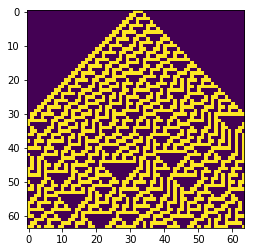

In [5]:
plt.imshow(one_d_auto(64,64,30))

Now we will calculate the entropy for the 1-dimensional automata. We know entropy is defined using the following formula.
$$  H = -\sum_{i=1}^n p_i \; log_2{p_i} = -\frac{1}{\ln 2} \,\sum_{i=1}^n p_i \; \ln{p_i} $$

In [6]:
def entropy_rule(grid,nsteps):
    line1=[]
    line2=[]
    for i in range(20,nsteps):
        line1.append(grid[len(grid[1])//3,i])
        line2.append(grid[2*len(grid[1])//3,i])
    unique1, counts1 = np.unique(line1, return_counts=True)
    unique2, counts2 = np.unique(line2, return_counts=True)
    probability_1= counts1/len(line1)
    probability_2= counts2/len(line2)
    entropy_1=-(1/np.log(2))*np.sum(probability_1*np.log(probability_1))
    entropy_2=-(1/np.log(2))*np.sum(probability_2*np.log(probability_2))
    mean_entropy=(entropy_1+entropy_2)/2
    return mean_entropy

In [7]:
entropy_rule(one_d_auto(64,64,30),64)

0.9932723150027822

In [8]:
rule_number=list(range(256))
entropy=[]
for values in rule_number:
    entropy.append(entropy_rule(one_d_auto(64,64,values),64))

def getKey(item):
    return item[0]

print(sorted(zip(entropy,rule_number ), reverse=True, key=getKey)[:5])

[(0.9962696551972943, 109), (0.9932723150027822, 30), (0.9902874207412604, 86), (0.9880103241183076, 50), (0.9880103241183076, 58)]


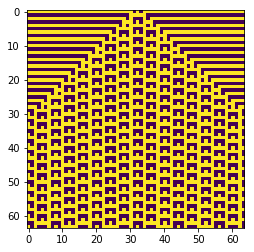

In [9]:
plt.imshow(one_d_auto(64,64,109))

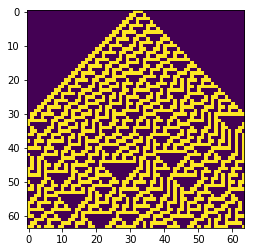

In [10]:
plt.imshow(one_d_auto(64,64,30))

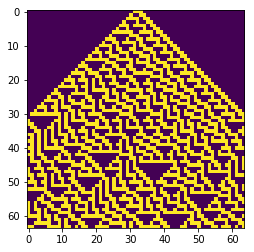

In [11]:
plt.imshow(one_d_auto(64,64,86))

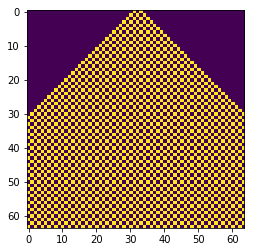

In [12]:
plt.imshow(one_d_auto(64,64,50))

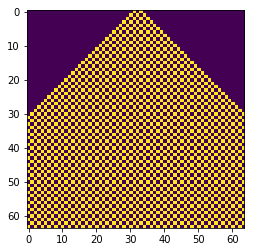

In [13]:
plt.imshow(one_d_auto(64,64,58))

In [14]:
rule_number_highest=[109,30,86,50,58]
random_rule=np.random.choice(rule_number_highest)
position=np.random.randint(0,len(one_d_auto(64,64,133)))
binary_list=one_d_auto(64,64,random_rule)[position]

binary=str(binary_list[0])

for values in range(1,len(binary_list)):
    binary=binary+str(binary_list[values])
print(int(binary,2))

13805745078272


Text(0,0.5,'Entropy')

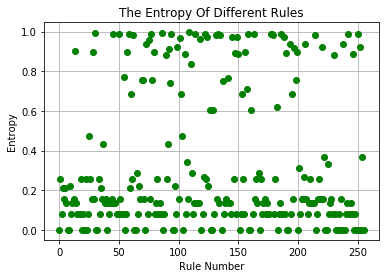

In [15]:
plt.plot(rule_number,entropy,"go")
plt.grid('on')
plt.title('The Entropy Of Different Rules')
plt.xlabel('Rule Number')
plt.ylabel('Entropy')



Initailly entropy was attempted to be calculated horizontally and summed over the different steps. But when finding the top 5 largest entopies and plotting them, the plots didn't look very random. 

So another appraoch was taken by calculating the entropy vertically. This comes to makes more sense because by calculating the entropy vertically, we can see the change of values. Thus being able to find the rules with the most random changes. 

First we thought to calculate the entropy of a single verticle line. But there could be the possibility that even though a certain line has a large entropy that might not be true for the rest of the lines. So then the next thought was to sum the entropies for all verticle lines. But a problem with this was that calculating the entopy towards the edges would be an issue because theres an interaction with the wall of some kind of absorbtion or reflection. 

So what was chosen to do at the end was to take the mean of two entropies. One calculated 1/3 and another 2/3 in the middle. This gives us both advantages of calculating for more than one verticle line and not taking into account of the edges. And after finding the top 5 largest entropies we can visually see that they are more random.

Now we ploted the Entropy for different rules. We can see that most rules have low entropy while few of them large entropy. Also, we see that almost all rules either have very large entropies or very low entropies with nothing in the middle.

We were able to generate a pseudorandom sequence 64-bit integer based on a cellular automaton using the highest entropy rule. 

Now we will look at the game of life. We will do this by defining a game of life class and a function that takes a grid with a known initail probability calculates the mean and standard deviation of the number of live cells. We will define standard deviation $\sigma$ and mean $\bar{x}$ as:

$$\bar{x} =\frac{ \sum\limits_{i=1}^{N}x}{N}$$

$$\sigma=\sqrt{\frac{1}{N}\sum\limits_{i=1}^{N}(x_i-\bar{x})}$$



In [16]:
class GameOfLife_basic:
    ''' basic object example for Conway's 2D automata "game of life"
    '''
    
    # a "class variable" is shared by all instances
    # this can be used for default configuration or for
    # keeping global stats ie. how many objects have been created
    default_grid = np.zeros( [31,21] )
    
    
    def __init__(self, grid=None):
        
        ''' the __init__ method is run whenever an instance is created
        '''      
        self.prob=0.5
        
        if grid is None:
            self._init_grid(random=True)
        else:
            self.grid = grid
        
        
    def _init_grid(self, grid=None, random=True):
        '''
        this could probably all be inside __init__, but it can be useful
        to factor it out so that we can call it separately
        '''

        self.grid = self.default_grid.copy() if grid is None else grid

        self._init_step()
        
        if random:
            self.randomize()
            
            
    def randomize(self):
        '''
        this serves as an example of a very simple method
        '''
        self.grid = np.random.rand(*self.grid.shape) > self.prob
        return self
    

    def _init_step(self):
        '''
        factor out calculations that are only required once per grid
        '''
        self.stepnum = 0
        
        nx, ny = self.grid.shape
        x,y = np.meshgrid( np.arange(nx), np.arange(ny), indexing='ij' )
        xx = np.array([x+1, x-1, x+0, x+0, x+1, x-1, x+1, x-1]) % nx
        yy = np.array([y+0, y+0, y+1, y-1, y+1, y-1, y-1, y+1]) % ny
        self.step_xy = xx,yy     
        
        
    def step(self, nsteps=100):
        ''' apply rules to evolve the grid by one step
        ?? how much of this code only needs to be run once per grid rather than at every step ??
        '''
        
        self.stepnum += 1
        grid = self.grid.copy()  # inefficient but safe?  -discuss 
        x, y = self.step_xy
        
        for indx in range(nsteps):            
            nnear = np.sum( grid[x,y] , axis=0 )
            grid[(nnear < 2) | (nnear > 3)] = 0
            grid[nnear==3] = 1
            
        self.grid = grid
        return self
    
    
    def plot(self, axes=None, flush=True):
        '''
        '''
        if axes is None:
            fig, axes = plt.subplots()
        axes.imshow( self.grid )
        return self

In [17]:
def mean(probability,itterations):
    total_true=[]
    add=0
    for i in range(itterations):
        obj=GameOfLife_basic()
        obj.prob=probability
        obj.randomize()
        #print(obj.grid)
        obj.step()
        total_true.append(np.sum(obj.grid))
    mean=np.sum(total_true)/itterations
    for j in total_true:
        add = add+(j-mean)**2
    std=(((1)/(itterations))*(add))**(1/2)
    return mean, std

In [18]:
a=mean(0.5,200)
print(a[0],"±",a[1])

61.815 ± 27.222615138887736


In [19]:
mean_values=[]
mean_error=[]

rule_number=np.linspace(0,1,11)
for values in rule_number:
    b=mean(values,100)
    mean_values.append(b[0])
    mean_error.append(b[1])
   

Text(0,0.5,'Mean Number of True Values')

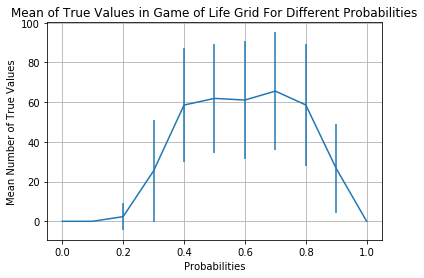

In [20]:
plt.errorbar(rule_number,mean_values,yerr=mean_error)
plt.grid('on')
plt.title('Mean of True Values in Game of Life Grid For Different Probabilities')
plt.xlabel('Probabilities')
plt.ylabel('Mean Number of True Values')



In [21]:
def GameOfLifePlot(probability):
    obj=GameOfLife_basic()
    obj.prob=probability
    obj.randomize()
    obj.step()
    obj.plot()
    return

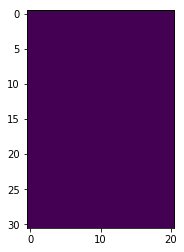

In [22]:
GameOfLifePlot(0.1)

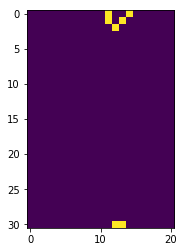

In [23]:
GameOfLifePlot(0.3)

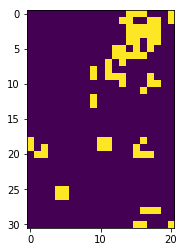

In [24]:
GameOfLifePlot(0.6)

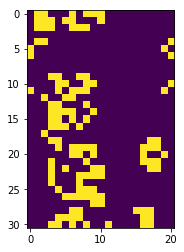

In [25]:
GameOfLifePlot(0.9)

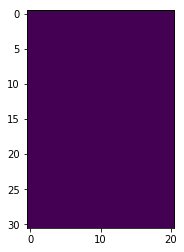

In [26]:
GameOfLifePlot(1)

We were able to calculate a mean value for grid with a starting probability of 0.5. The values we would get were around 30-50. The standard deviation was fairly large being almost half of whatever value we would calculate for our mean. This obviously makes sense because our mean value changes every time we made the calculation. I guess a possible way to decrease incertienty would be run the calculation for more iterations but this would be more time intensive.

After we varied probability of the initial grid and compared it to the number of true values that occur during a steady state. We can see when the probability is approximately lower than 0.2 we generally have no live cells. Between a probability of 0.4 and 0.8 we have alot of true values. Between 0.8 and 1, the amount of true values quickly decrease. Plots around these points can visually show us that the graph is correct.

Looking at the begginning and end of the graph can help to confirm the rules that dictate which cells are alive and dead. Looking at the begginning we can see that theres a little area where the number of truthes stay at zero before inceasing. This could possibly tell us that the rule is effecting by the number of alive cells. So there needs to be a minimum about of live cells for anything to take effect. The end of the graph can tells us that the rule kills cells that have too many alive cells around them.

By analyzing the graph we get a basic understanding of how the rules funciton. 

## Conclusion

In this report we will first start with creating a basic 1-dimensional cellular automata. Using entropy we will determine which rules are the most random and use them to calculate a most random 64-bit interger we can. Following that we will work with a game of life, first looking at the mean number of live cells once reaching a steady state. Finally we will vary the probability to see how that effects the mean number of live cells once reaching a steady state.

In this report we looked at 1-dimensional cellular automata. We determined rules 109, 30, 86, 50, and 58 had the highest entropy. Using this analysis we were able to create a random 64-bit value using a high entropy rule. After we looked at the game of life. First finding the mean number of lives cells once reaching steady state. Finally we looking at the effects to lives cells as we varied the intial proability of the grid. Using this we were able to do confirm how the rules worked.